In [1]:
!pip install -U kaleido

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Changing the working directory to the root
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
# Install TimeSynth if not installed already
!pip install git+https://github.com/TimeSynth/TimeSynth.git

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-bz7fn9k4
  Running command git clone --filter=blob:none --quiet https://github.com/TimeSynth/TimeSynth.git /tmp/pip-req-build-bz7fn9k4
  Resolved https://github.com/TimeSynth/TimeSynth.git to commit e50cdb9015d415adf46a4eae161a087c5c378564
  Preparing metadata (setup.py) ... done


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import timesynth as ts
import pandas as pd
np.random.seed()

# Data Generating Process and Synthetic Time Series

In [15]:
def plot_time_series(time, values, label, legends=None):
    if legends is not None:
        assert len(legends)==len(values)
    if isinstance(values, list):
        series_dict = {"Time": time}
        for v, l in zip(values, legends):
            series_dict[l] = v
        plot_df = pd.DataFrame(series_dict)
        plot_df = pd.melt(plot_df,id_vars="Time",var_name="ts", value_name="Value")
    else:
        series_dict = {"Time": time, "Value": values, "ts":""}
        plot_df = pd.DataFrame(series_dict)

    if isinstance(values, list):
        fig = px.line(plot_df, x="Time", y="Value", line_dash="ts")
    else:
        fig = px.line(plot_df, x="Time", y="Value")
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title={
        'text': label,
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        titlefont={
            "size": 25
        },
        yaxis=dict(
            title_text="Value",
            titlefont=dict(size=12),
        ),
        xaxis=dict(
            title_text="Time",
            titlefont=dict(size=12),
        )
    )
    return fig

def generate_timeseries(signal, noise=None):
    time_sampler = ts.TimeSampler(stop_time=20)
    regular_time_samples = time_sampler.sample_regular_time(num_points=100)
    timeseries = ts.TimeSeries(signal_generator=signal, noise_generator=noise)
    samples, signals, errors = timeseries.sample(regular_time_samples)
    return samples, regular_time_samples, signals, errors

os.makedirs("imgs/chapter_1", exist_ok=True)

## White Noise

In [7]:
# Generate the time axis with sequential numbers upto 200
time = np.arange(200)
# Sample 200 hundred random values
values = np.random.randn(200)*100
fig = plot_time_series(time, values, "")
fig.write_image("imgs/chapter_1/white_noise_process.png")
fig.show()

## Red Noise

In [8]:
# Setting the correlation coefficient
r = 0.4
# Generate the time axis
time = np.arange(200)
# Generate white noise
white_noise = np.random.randn(200)*100
# Create Red Noise by introducing correlation between subsequent values in the white noise
values = np.zeros(200)
for i, v in enumerate(white_noise):
    if i==0:
        values[i] = v
    else:
        values[i] = r*values[i-1]+ np.sqrt((1-np.power(r,2))) *v


fig = plot_time_series(time, values, "")
fig.write_image("imgs/chapter_1/red_noise_process.png")
fig.show()

## Sinusoidal

In [9]:
#Sinusoidal Signal with Amplitude=1.5 & Frequency=0.25
signal_1 =ts.signals.Sinusoidal(amplitude=1.5, frequency=0.25)
#Sinusoidal Signal with Amplitude=1 & Frequency=0. 5
signal_2 = ts.signals.Sinusoidal(amplitude=1, frequency=0.5)
#Generating the time series
samples_1, regular_time_samples, signals_1, errors_1 = generate_timeseries(signal=signal_1)
samples_2, regular_time_samples, signals_2, errors_2 = generate_timeseries(signal=signal_2)

In [10]:
fig = plot_time_series(regular_time_samples,
                 [samples_1, samples_2],
                 "",
                 legends=["Amplitude = 1.5 | Frequency = 0.25", "Amplitude = 1 | Frequency = 0.5"])
fig.write_image("imgs/chapter_1/sinusoidal_waves.png")
fig.show()

## Pseudo Periodic

In [11]:
# PseudoPeriodic signal with Amplitude=1 & Frequency=0.25
signal = ts.signals.PseudoPeriodic(amplitude=1, frequency=0.25)
#Generating Timeseries
samples, regular_time_samples, signals, errors = generate_timeseries(signal=signal)


In [12]:
fig = plot_time_series(regular_time_samples,
                 samples,
                 "")
fig.write_image("imgs/chapter_1/pseudo_process.png")
fig.show()

## Auto Regressive

In [ ]:
# Autoregressive signal with parameters 1.5 and -0.75
# y(t) = 1.5*y(t-1) - 0.75*y(t-2)
signal=ts.signals.AutoRegressive(ar_param=[1.5, -0.75])
#Generate Timeseries
samples, regular_time_samples, signals, errors = generate_timeseries(signal=signal)

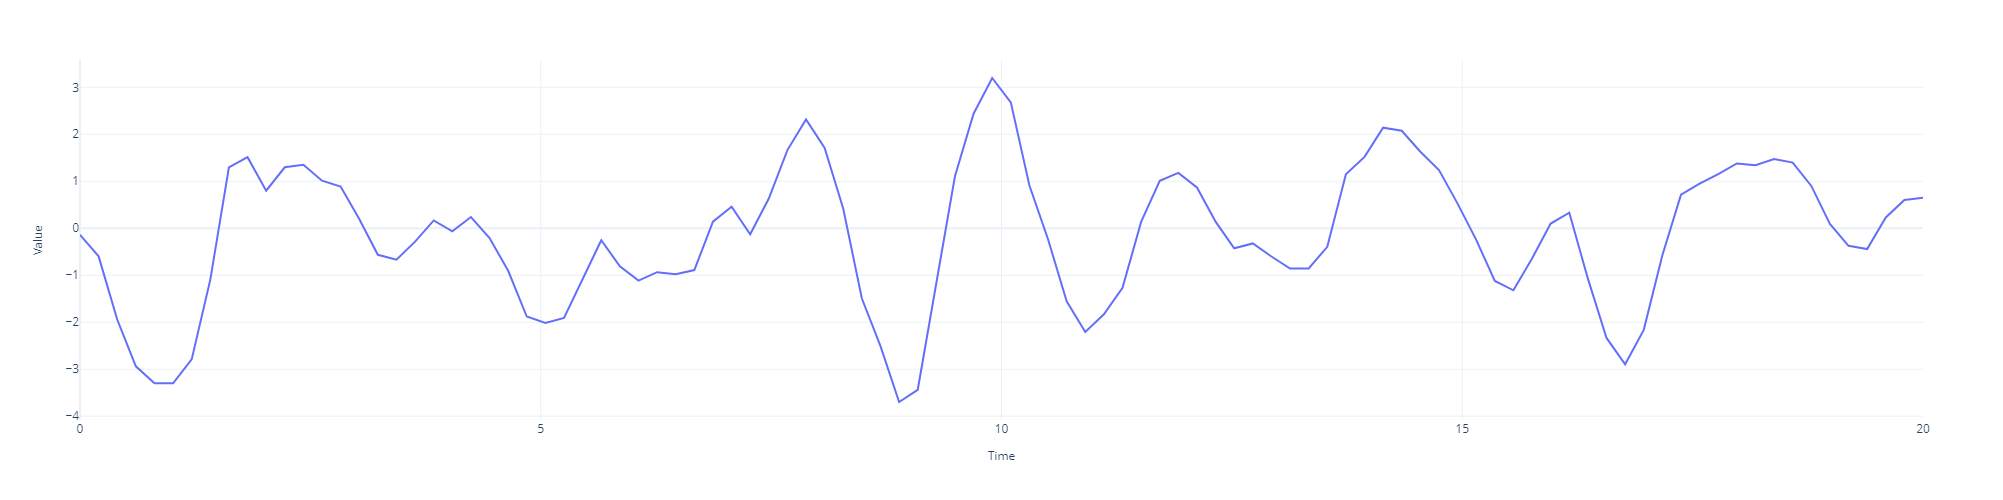

In [ ]:
fig = plot_time_series(regular_time_samples,
                 samples,
                 "")
fig.write_image("imgs/chapter_1/auto_regressive.png")
fig.show()

## Mix and Match

In [18]:
#Generating Pseudo Periodic Signal
pseudo_samples, regular_time_samples, _, _ = generate_timeseries(signal=ts.signals.PseudoPeriodic(amplitude=1, frequency=0.25), noise=ts.noise.GaussianNoise(std=0.3))
# Generating an Autoregressive Signal
ar_samples, regular_time_samples, _, _ = generate_timeseries(signal=ts.signals.AutoRegressive(ar_param=[1.5, -0.75]))
# Combining the two signals using a mathematical equation
timeseries_ = pseudo_samples*2+ar_samples

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

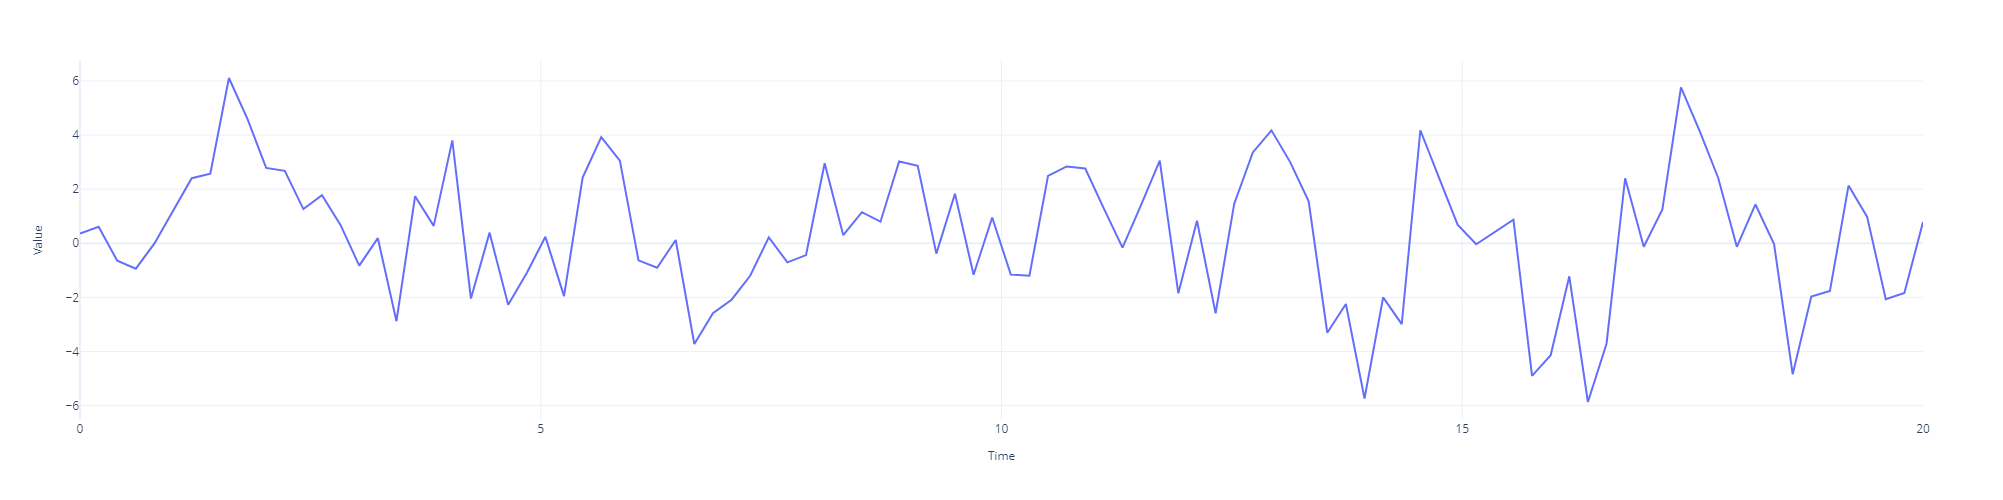

In [ ]:
fig = plot_time_series(regular_time_samples,
                 timeseries_,
                 "")
fig.write_image("imgs/chapter_1/mix_n_match.png")
fig.show()

## Non-Stationary: Sinusoidal with Trend and White Noise

In [16]:
# Sinusoidal Signal with Amplitude=1 & Frequency=0.25
signal=ts.signals.Sinusoidal(amplitude=1, frequency=0.25)
# White Noise with standar deviation = 0.3
noise=ts.noise.GaussianNoise(std=0.3)
# Generate the time series
sinusoidal_samples, regular_time_samples, _, _ = generate_timeseries(signal=signal, noise=noise)
# Regular_time_samples is a linear incteasing time axis and can be used as a trend
trend = regular_time_samples*0.4
# Combining the signal and trend
timeseries_ = sinusoidal_samples+trend

In [17]:
fig = plot_time_series(regular_time_samples,
                 timeseries_,
                 "")
fig.write_image("imgs/chapter_1/non_stationary.png")
fig.show()

## Non-Stationary: Sinusoidal and Time Varying Noise

In [ ]:
sinusoidal_samples, regular_time_samples, _, _ = generate_timeseries(signal=ts.signals.Sinusoidal(amplitude=1, frequency=0.25))

In [ ]:
noise = [np.random.randn()*np.sqrt(i) for i, v in enumerate(regular_time_samples)]

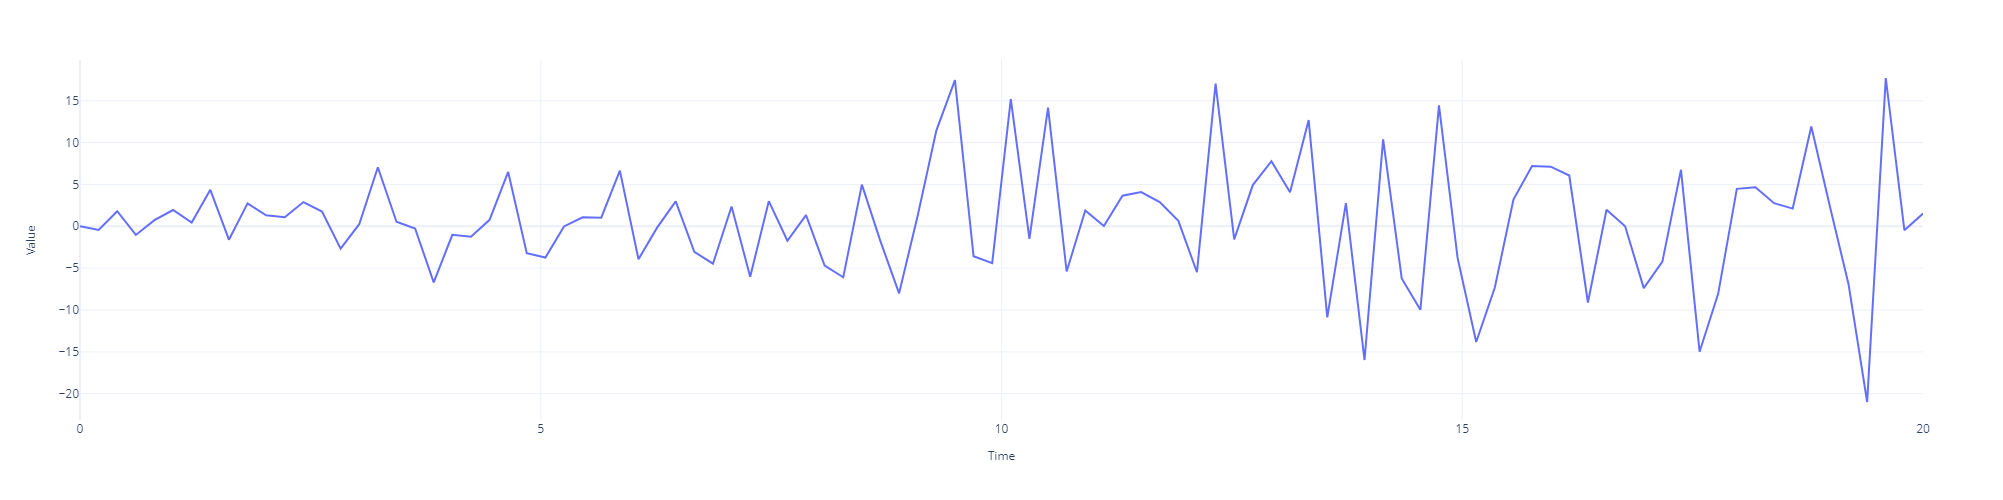

In [ ]:
fig = plot_time_series(regular_time_samples,
                 sinusoidal_samples+noise,
                 "")
fig.write_image("imgs/chapter_1/non_stationary_sinusoidal.png")
fig.show()